## 환경 설정
### 필요한 모듈 등 임포트하기

In [1]:
import re, os
import random, math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

2024-12-04 17:48:27.314746: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 17:48:27.441607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733302107.490917  105432 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733302107.505775  105432 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 17:48:27.613158: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Number of replicas: 1
2.18.0


### 데이터 불러오기 및 경로 지정하기

In [2]:
# Kaggle 데이터 다운로드
import kagglehub
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# cash 디렉토리에서 작업 디렉토리로 복사
from distutils.dir_util import copy_tree
ROOT_PATH = os.path.join(os.getenv('HOME'), 'Main03')
copy_tree(path, ROOT_PATH)

# 데이터 경로 변수
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

# 지정된 경로 확인
print(ROOT_PATH)
print(TRAIN_PATH)
print(VAL_PATH)
print(TEST_PATH)

/home/technocracy90/Main03
/home/technocracy90/Main03/chest_xray/train/*/*
/home/technocracy90/Main03/chest_xray/val/*/*
/home/technocracy90/Main03/chest_xray/test/*/*


## 데이터 준비
### 데이터 재분류하기

In [3]:
# 데이터 종류별 취합
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(f"학습 데이터: {len(train_filenames)}")
print(f"검증 데이터: {len(val_filenames)}")
print(f"테스트 데이터: {len(test_filenames)}")

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(f"재분배 후 학습 데이터: {len(train_filenames)}")
print(f"재분배 후 검증 데이터: {len(val_filenames)}")

# 데이터셋 작성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
total_list_ds = tf.data.Dataset.from_tensor_slices(filenames)

학습 데이터: 5216
검증 데이터: 16
테스트 데이터: 624
재분배 후 학습 데이터: 4185
재분배 후 검증 데이터: 1047


I0000 00:00:1733302118.032714  105432 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9571 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 15

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [6]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 데이터 전처리 및 라벨링하기

In [7]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    label = 0

    if parts[-2] == "PNEUMONIA":
        label = 1
    
    return int(label)   # 폐렴이면 1, 노말이면 0

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

# 데이터셋에 라벨 부여하기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
total_ds = total_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 데이터셋 형태 확인
for image, label in train_ds.take(10):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0
Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  0
Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  0
Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  0
Image shape:  (180, 180, 3)
Label:  0


2024-12-04 17:48:38.603110: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
# 데이터 어그멘테이션
def augment(image,label):
    contrast_factor = random.uniform(0.9, 1.1)
    image = tf.image.adjust_contrast(image, contrast_factor)
    return image, label

In [9]:
# 데이터셋을 학습을 위해 준비시키기

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
        augment,       # augment 함수 적용
        num_parallel_calls=2)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
total_ds = prepare_for_training(total_ds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.026138961..1.0093656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009822339..1.0149734].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.015326083..1.0097599].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013065457..1.0092067].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01121375..1.0093164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0111169815..1.0083412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range

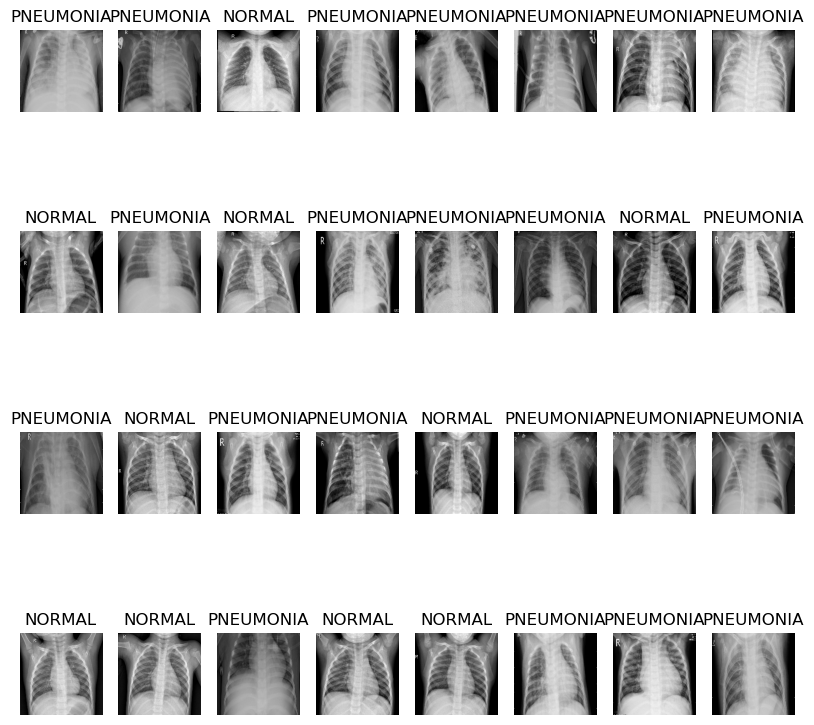

In [10]:
# 준비된 데이터셋 확인하기
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [11]:
# 테스트 데이터셋 준비

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## 모델 작성 및 학습

### 모델 작성

In [16]:
# 컨볼루션 블럭
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

# 밀집층 블럭
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

# Residua 블럭
def residual_block(x, filters):
    shortcut = x
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([shortcut, x])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [17]:
# 모델 빌드하기
def build_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = residual_block(x, 256)
    x = residual_block(x, 256)

    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = residual_block(x, 512)
    x = residual_block(x, 512)

    x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

train_model = build_model((IMAGE_SIZE[0], IMAGE_SIZE[1], 3), 1)

In [18]:
# 모델 컴파일하기
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')]

train_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS)

In [19]:
# imbalance 샘플에 대한 가중치 부여

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 모델 학습

In [20]:
# 모델 훈련
history = train_model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight)

Epoch 1/15


I0000 00:00:1733302191.532702  106058 service.cc:148] XLA service 0x7fc3d0004160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733302191.533893  106058 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-12-04 17:49:52.583397: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733302193.396279  106058 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-04 17:49:54.108765: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6302', 508 bytes spill stores, 512 bytes spill loads

2024-12-04 17:49:54.235654: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6302', 52 byt

130/130 ━━━━━━━━━━━━━━━━━━━━ 56s 233ms/step - accuracy: 0.7195 - loss: 5.8618 - precision: 0.8732 - recall: 0.7316 - val_accuracy: 0.7344 - val_loss: 1.2181 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 2/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 229ms/step - accuracy: 0.9118 - loss: 0.2337 - precision: 0.9753 - recall: 0.9052 - val_accuracy: 0.7080 - val_loss: 1.8587 - val_precision: 0.7286 - val_recall: 0.9615
Epoch 3/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 229ms/step - accuracy: 0.8757 - loss: 0.3097 - precision: 0.9574 - recall: 0.8715 - val_accuracy: 0.7598 - val_loss: 0.5657 - val_precision: 0.9135 - val_recall: 0.7437
Epoch 4/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 238ms/step - accuracy: 0.9287 - loss: 0.1700 - precision: 0.9755 - recall: 0.9287 - val_accuracy: 0.8564 - val_loss: 0.3388 - val_precision: 0.9660 - val_recall: 0.8333
Epoch 5/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 228ms/step - accuracy: 0.9364 - loss: 0.1487 - precision: 0.9796 - recall: 0.9335 - val_accuracy: 0.8828 - val_loss

### 학습결과 시각화 및 검증대상모델 학습

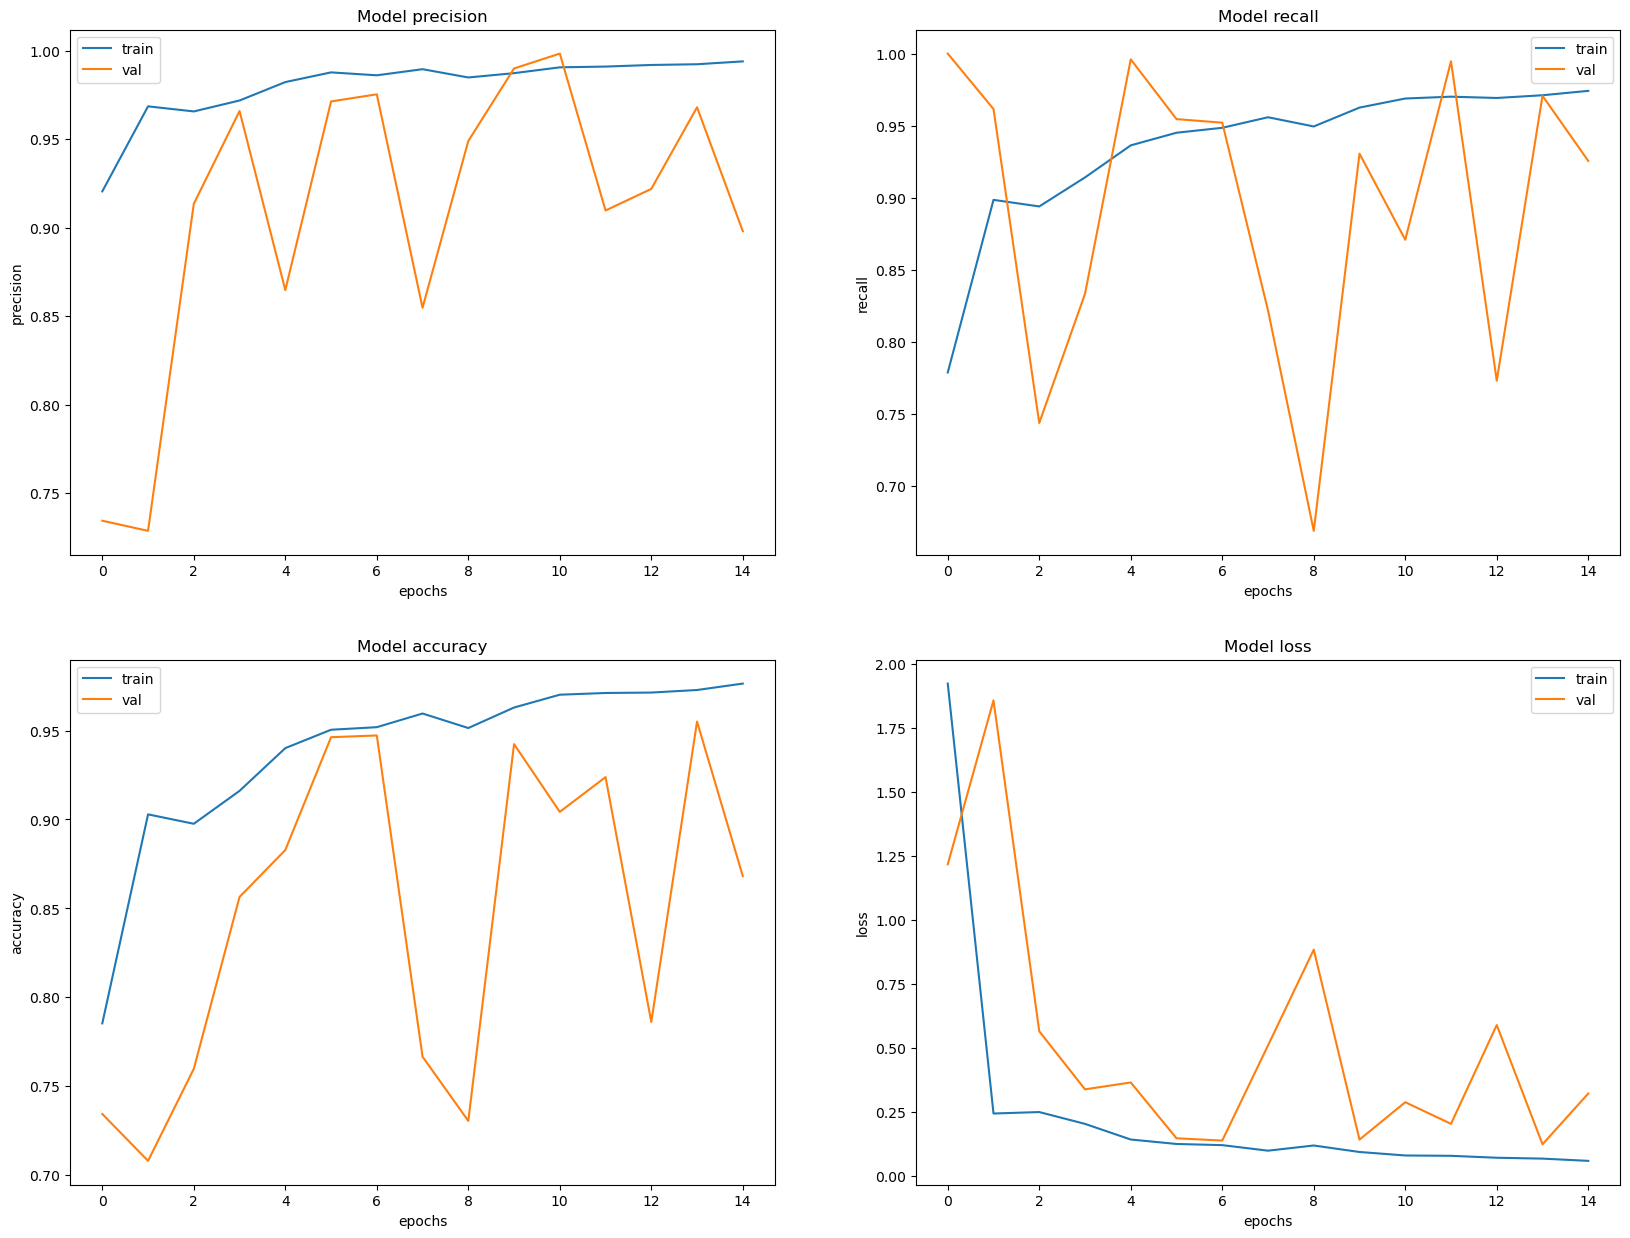

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

Epoch 1/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 193ms/step - accuracy: 0.7986 - loss: 3.6648 - precision: 0.9184 - recall: 0.8571
Epoch 2/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 196ms/step - accuracy: 0.9247 - loss: 0.2226 - precision: 0.9749 - recall: 0.9227
Epoch 3/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.9575 - loss: 0.1213 - precision: 0.9881 - recall: 0.9541
Epoch 4/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 190ms/step - accuracy: 0.9578 - loss: 0.1297 - precision: 0.9835 - recall: 0.9597
Epoch 5/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 202ms/step - accuracy: 0.9539 - loss: 0.1289 - precision: 0.9837 - recall: 0.9539
Epoch 6/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 191ms/step - accuracy: 0.9579 - loss: 0.1164 - precision: 0.9872 - recall: 0.9557


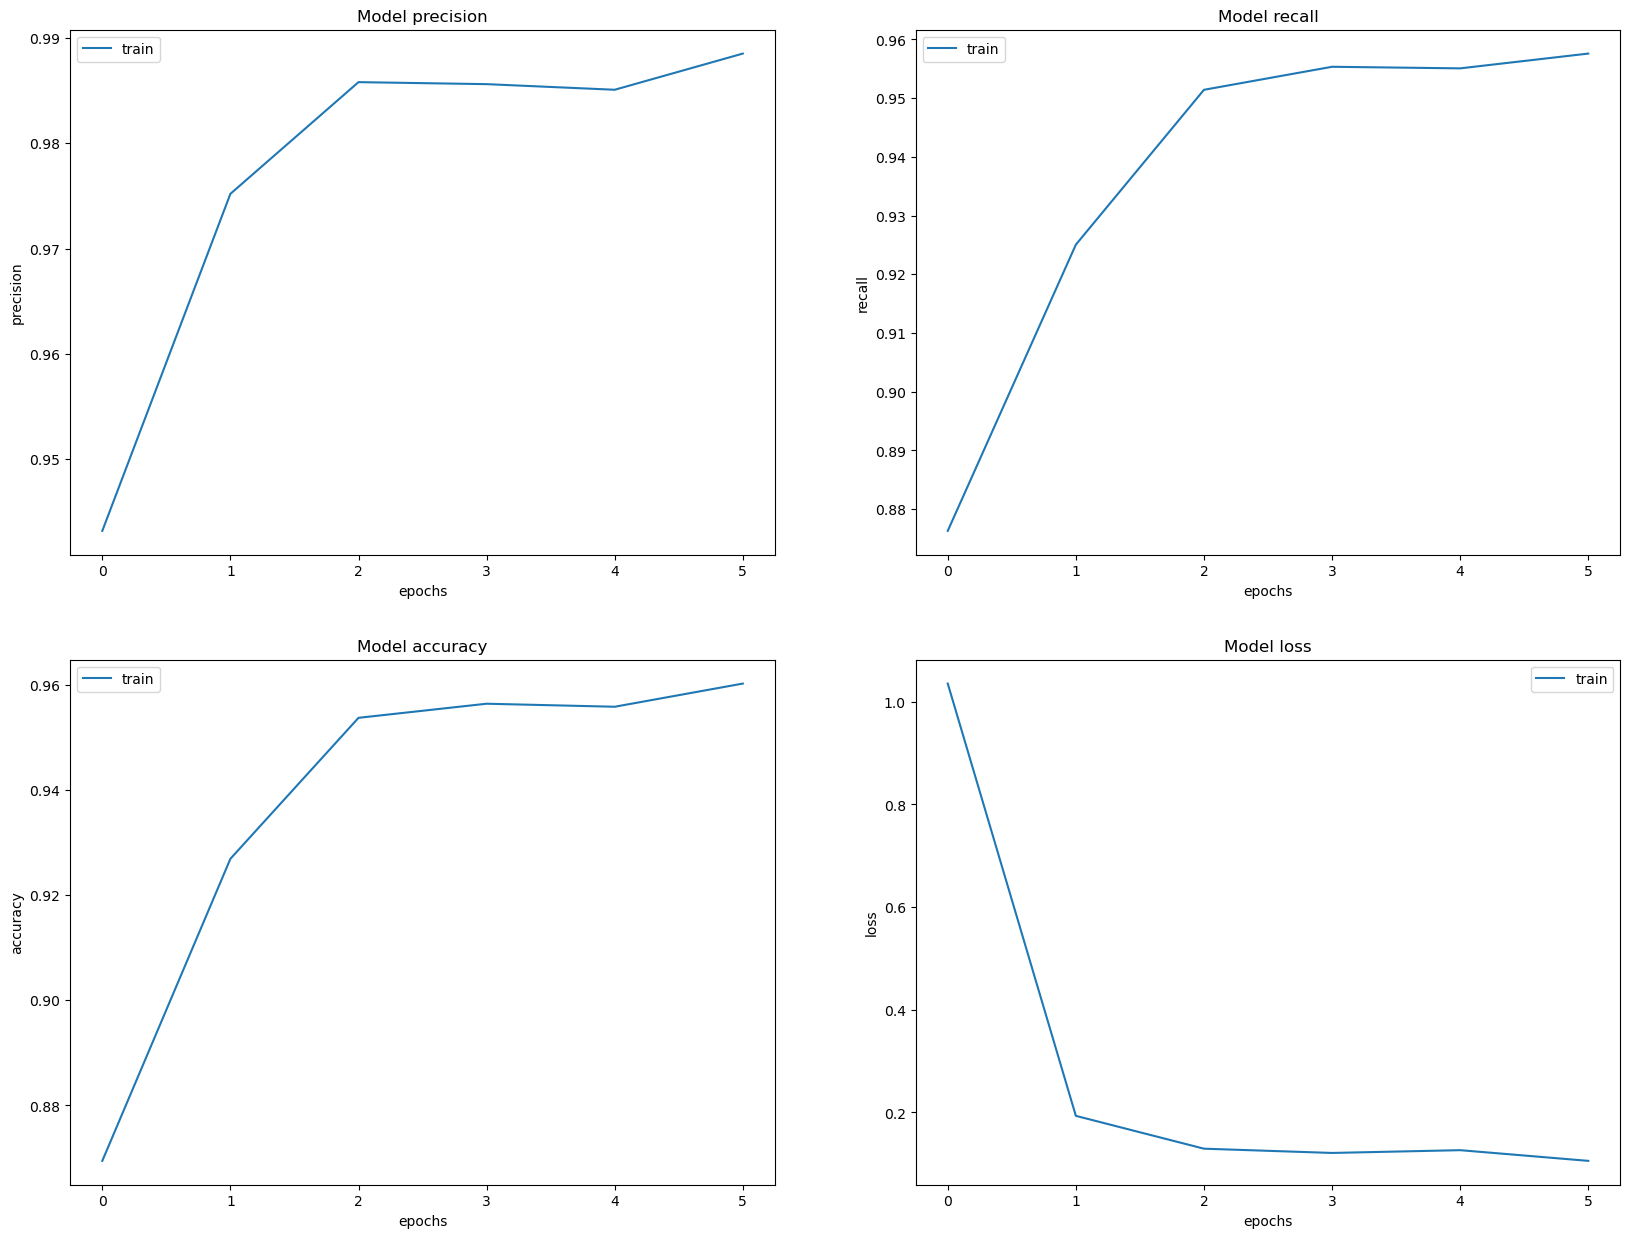

In [23]:
# 검증대상 모델 준비
test_model = build_model((IMAGE_SIZE[0], IMAGE_SIZE[1], 3), 1)

test_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS)

# 검증대상 모델 훈련
history = test_model.fit(
        total_ds,
        steps_per_epoch = (TRAIN_IMG_COUNT + VAL_IMG_COUNT) // BATCH_SIZE,
        epochs = 6,
        class_weight=class_weight)

# 검증대상 모델 시각화
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## 모델 검증

In [25]:
loss, accuracy, precision, recall = test_model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.8018 - loss: 0.4977 - precision: 0.8032 - recall: 0.8963
Loss: 0.5407254695892334,
Accuracy: 0.7788461446762085,
Precision: 0.78899085521698,
Recall: 0.8820512890815735


## 회고
-  ResNet을 쓰기 전에는 GPU가 워낙 안 돌아서 세팅을 잘못 했나 했는데 ResNet 쓰니까 힘차게 돌아간다
-  적어도 `x = tf.keras.layers.Add()([shortcut, x])`는 알려주고 ResNet 작성하라고 하지 그랬어요
-  이전 노드에서 배웠던 것 같기도 하고 이번 모듈은 워낙 나태했어서 내 잘못인 거 같기도 하다
-  데이터 특성에 맞다고 생각되는 증강을 한 효과일거라고 생각하기도 하지만 역시 배치사이즈 큰 게 최고인가